# Advanced Analysis of Yelp Reviews for Asian Restaurants in the United States #

This notebook continues the exploratory data analysis by diving deeper into the Yelp reviews dataset for Asian restaurants in the United States. We will perform:

* Topic Modeling using Latent Dirichlet Allocation (LDA)
* Aspect-Based Sentiment Analysis
* Temporal Analysis (if time permits)
* Further insights and visualizations


## 1. Introduction ##

In this notebook, we build upon the previous exploratory data analysis to perform advanced analyses on Yelp reviews of Asian restaurants in the United States. The focus is on uncovering hidden themes in the reviews through topic modeling and analyzing customer sentiments towards specific aspects of their dining experience.

## 2. Import Libraries ##

We start by importing the necessary libraries for data manipulation, natural language processing, and visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# NLP libraries
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.corpus import stopwords
from nltk import word_tokenize, download
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Visualization libraries
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# For handling warnings
import warnings
warnings.filterwarnings('ignore')

# For NLP preprocessing
#download('stopwords')
#download('punkt')
#download('vader_lexicon')

# Set visualization style
sns.set(style='whitegrid')

## 3. Load Preprocessed Data ##

We load the preprocessed DataFrame saved from the previous analysis.

In [2]:
# Load the preprocessed data
df = pd.read_csv('asian_restaurants_reviews_us_preprocessed.csv')

# Display the first few rows
print("Preprocessed Data:")
display(df.head())

Preprocessed Data:


,review_id,user_id,business_id,stars_review,useful,funny,cool,text,date,name,...,stars_business,review_count,is_open,attributes,categories,hours,is_asian,review_length,tokens,sentiment_score
0,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Zaika,...,4.0,181,1,"{'Caters': 'True', 'Ambience': ""{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21...",True,40,"['wow', 'yummy', 'different', 'delicious', 'fa...",0.9588
1,pUycOfUwM8vqX7KjRRhUEA,59MxRhNVhU9MYndMkz0wtw,gebiRewfieSdtt17PTW6Zg,3,0,0,0,Had a party of 6 here for hibachi. Our waitres...,2016-07-25 07:31:06,Hibachi Steak House & Sushi Bar,...,3.5,488,1,"{'Corkage': 'False', 'RestaurantsTakeOut': 'Tr...","Steakhouses, Sushi Bars, Restaurants, Japanese",{'Monday': '0:0-0:0'},True,97,"['party', 'hibachi', 'brought', 'separate', 's...",0.9782
2,eCiWBf1CJ0Zdv1uVarEhhw,OhECKhQEexFypOMY6kypRw,vC2qm1y3Au5czBtbhc-DNw,4,0,0,0,"Yes, this is the only sushi place in town. How...",2013-09-04 03:48:20,Sushi Teri,...,3.0,167,1,"{'RestaurantsReservations': 'True', 'NoiseLeve...","Restaurants, Sushi Bars","{'Monday': '17:0-22:0', 'Tuesday': '17:0-22:0'...",True,58,"['yes', 'sushi', 'town', 'however', 'great', '...",0.9622
3,G_5UczbCBJriUAbxz3J7Tw,clWLI5OZP2ad25ugMVI8gg,x4XdNhp0Xn8lOivzc77J-g,5,0,0,0,Best thai food in the area. Everything was au...,2013-08-15 15:27:51,Thai Place Restaurant,...,4.5,222,1,"{'OutdoorSeating': 'False', 'RestaurantsDelive...","Thai, Restaurants","{'Tuesday': '17:0-21:30', 'Wednesday': '17:0-2...",True,18,"['best', 'thai', 'everything', 'authentic', 'd...",0.8910
4,r2IBPY_E8AE5_GpsqlONyg,IKbjLnfBQtEyVzEu8CuOLg,VJEzpfLs_Jnzgqh5A_FVTg,4,0,0,0,It was my fiance's birthday and he decided he ...,2014-04-01 13:05:18,Jasmine Rice - Rittenhouse,...,3.5,307,1,"{'RestaurantsPriceRange2': '2', 'RestaurantsAt...","Soup, Thai, Restaurants, Salad","{'Monday': '13:30-22:30', 'Tuesday': '13:30-22...",True,214,"['fiances', 'birthday', 'decided', 'wanted', '...",0.9854


## 4. Topic Modeling with LDA ##

We perform topic modeling to uncover hidden themes in the reviews.

### 4.1 Prepare Data for LDA ###
We need to prepare the data by creating a dictionary and corpus suitable for LDA.

#### 4.1.1 Preprocessing Text Data ####

If the tokenized text is not available, we need to preprocess the text again. However, since we have preprocessed tokens, we can proceed.

In [3]:
# Check if 'tokens' column exists
if 'tokens' in df.columns:
    # Convert string representation of lists to actual lists
    df['tokens'] = df['tokens'].apply(eval)
else:
    # Preprocess text if 'tokens' column is not available
    stop_words = set(stopwords.words('english'))

    # Add restaurant-specific stop words as before
    restaurant_stop_words = [
        'restaurant', 'food', 'place', 'menu', 'order', 'ordered', 'eat', 'ate',
        'dish', 'dishes', 'meal', 'meals', 'server', 'servers', 'waiter', 'waitress',
        'staff', 'table', 'tables', 'seat', 'seated', 'drinks', 'drink', 'appetizer',
        'appetizers', 'main', 'course', 'courses', 'dessert', 'desserts', 'lunch',
        'dinner', 'breakfast', 'brunch', 'location', 'area', 'experience', 'experiences',
        'customer', 'customers', 'service', 'services', 'takeout', 'take', 'out', 'time',
        'times', 'visit', 'visits', 'visited', 'day', 'days', 'night', 'nights', 'people',
        'person', 'group', 'groups', 'friend', 'friends', 'family'
    ]
    stop_words.update(restaurant_stop_words)

    # Preprocess text
    def preprocess_text(text):
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text)
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]
        return tokens

    df['tokens'] = df['text'].apply(preprocess_text)

#### 4.1.2 Creating Dictionary and Corpus ####

In [4]:
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(df['tokens'])

# Filter out extremes to remove very rare and very common words
dictionary.filter_extremes(no_below=15, no_above=0.5)

# Create the Bag-of-Words corpus
corpus = [dictionary.doc2bow(text) for text in df['tokens']]

# Print basic information
print(f'Number of unique tokens: {len(dictionary)}')
print(f'Number of documents: {len(corpus)}')

Number of unique tokens: 23923
Number of documents: 591773


### 4.2 Build LDA Model ###
We build the LDA model to discover topics in the reviews.

#### 4.2.1 Determining Optimal Number of Topics ####

We test different numbers of topics and calculate coherence scores to find the optimal number.

In [5]:
coherence_scores = []
model_list = []
topic_range = range(2, 11)

for num_topics in topic_range:
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=42,
                         chunksize=1000,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
    model_list.append(lda_model)
    coherencemodel = CoherenceModel(model=lda_model, texts=df['tokens'], dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherencemodel.get_coherence())
    print(f'Number of Topics: {num_topics}, Coherence Score: {coherencemodel.get_coherence():.4f}')

Number of Topics: 2, Coherence Score: 0.4194
Number of Topics: 3, Coherence Score: 0.4478
Number of Topics: 4, Coherence Score: 0.4394
Number of Topics: 5, Coherence Score: 0.5225
Number of Topics: 6, Coherence Score: 0.5049
Number of Topics: 7, Coherence Score: 0.5342
Number of Topics: 8, Coherence Score: 0.4880
Number of Topics: 9, Coherence Score: 0.5519
Number of Topics: 10, Coherence Score: 0.5357


#### 4.2.2 Plotting Coherence Scores ####

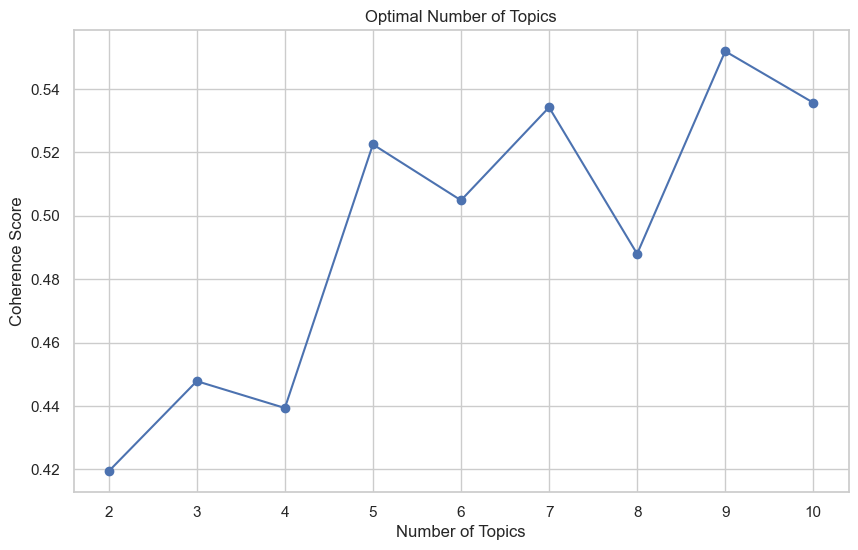

In [6]:
plt.figure(figsize=(10,6))
plt.plot(topic_range, coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Optimal Number of Topics')
plt.show()

### 4.3 Explore and Interpret Topics ###

In [11]:
optimal_num_topics = 9  # Replace with the optimal number determined

# Train the final LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=optimal_num_topics,
                     random_state=42,
                     chunksize=1000,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

#### 4.3.1 Display Topics ####

In [12]:
from pprint import pprint

# Print the keywords in the topics
pprint(lda_model.print_topics(num_words=10))

[(0,
  '0.061*"ramen" + 0.053*"pho" + 0.049*"tea" + 0.035*"pork" + 0.032*"broth" + '
  '0.021*"boba" + 0.021*"vietnamese" + 0.020*"bowl" + 0.017*"terminal" + '
  '0.016*"mi"'),
 (1,
  '0.051*"great" + 0.027*"delicious" + 0.025*"best" + 0.022*"love" + '
  '0.021*"always" + 0.021*"definitely" + 0.021*"try" + 0.018*"back" + '
  '0.018*"fresh" + 0.018*"amazing"'),
 (2,
  '0.066*"good" + 0.034*"like" + 0.029*"really" + 0.024*"get" + 0.016*"im" + '
  '0.015*"dont" + 0.014*"chinese" + 0.014*"much" + 0.014*"pretty" + '
  '0.013*"little"'),
 (3,
  '0.041*"chicken" + 0.031*"rice" + 0.026*"thai" + 0.023*"sauce" + '
  '0.022*"fried" + 0.021*"spicy" + 0.019*"soup" + 0.016*"flavor" + '
  '0.015*"shrimp" + 0.015*"hot"'),
 (4,
  '0.016*"us" + 0.012*"got" + 0.012*"came" + 0.012*"didnt" + 0.011*"even" + '
  '0.011*"would" + 0.011*"back" + 0.010*"one" + 0.009*"could" + 0.009*"went"'),
 (5,
  '0.085*"indian" + 0.047*"chicken" + 0.046*"buffet" + 0.041*"naan" + '
  '0.033*"masala" + 0.026*"lamb" + 0.023*"ti

### 4.4 Visualize Topics ###
We use pyLDAvis to visualize the topics interactively.

In [13]:
# Prepare the visualization
pyLDAvis.enable_notebook()
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

# Display the visualization
pyLDAvis.display(lda_display)


### 4.5 Assign Topics to Reviews ###
We assign the dominant topic to each review.

In [15]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Initialize an empty list to hold the results
    sent_topics_list = []

    for i, row_list in enumerate(ldamodel[corpus]):
        if ldamodel.per_word_topics:
            row = row_list[0]
        else:
            row = row_list

        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the dominant topic, percentage contribution, and keywords for each review
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_list.append([int(topic_num), round(prop_topic, 4), topic_keywords])
            else:
                break

    # Create a DataFrame from the list
    sent_topics_df = pd.DataFrame(sent_topics_list, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

    # Add original text to the end of the output
    contents = texts.reset_index(drop=True)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

# Call the function
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['text'])

# Format the DataFrame
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Display the top 5 rows
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.2854,"great, delicious, best, love, always, definite...","Wow! Yummy, different, delicious. Our favo..."
1,1,4,0.3834,"us, got, came, didnt, even, would, back, one, ...",Had a party of 6 here for hibachi. Our waitres...
2,2,1,0.3023,"great, delicious, best, love, always, definite...","Yes, this is the only sushi place in town. How..."
3,3,1,0.4392,"great, delicious, best, love, always, definite...",Best thai food in the area. Everything was au...
4,4,3,0.2959,"chicken, rice, thai, sauce, fried, spicy, soup...",It was my fiance's birthday and he decided he ...


## 5. Aspect-Based Sentiment Analysis ##

We analyze sentiments associated with each identified topic.

### 5.1 Sentiment Analysis per Topic ###
#### 5.1.1 Merge Dominant Topics with Original Data ####

In [17]:
# Merge the dominant topic back into the main DataFrame
df_aspect_sentiment = pd.merge(df, df_dominant_topic[['Document_No', 'Dominant_Topic']], left_index=True, right_on='Document_No', how='left')

# Display the first few rows
df_aspect_sentiment.head()


,review_id,user_id,business_id,stars_review,useful,funny,cool,text,date,name,...,is_open,attributes,categories,hours,is_asian,review_length,tokens,sentiment_score,Document_No,Dominant_Topic
0,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Zaika,...,1,"{'Caters': 'True', 'Ambience': ""{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21...",True,40,"[wow, yummy, different, delicious, favorite, l...",0.9588,0,1
1,pUycOfUwM8vqX7KjRRhUEA,59MxRhNVhU9MYndMkz0wtw,gebiRewfieSdtt17PTW6Zg,3,0,0,0,Had a party of 6 here for hibachi. Our waitres...,2016-07-25 07:31:06,Hibachi Steak House & Sushi Bar,...,1,"{'Corkage': 'False', 'RestaurantsTakeOut': 'Tr...","Steakhouses, Sushi Bars, Restaurants, Japanese",{'Monday': '0:0-0:0'},True,97,"[party, hibachi, brought, separate, sushi, ord...",0.9782,1,4
2,eCiWBf1CJ0Zdv1uVarEhhw,OhECKhQEexFypOMY6kypRw,vC2qm1y3Au5czBtbhc-DNw,4,0,0,0,"Yes, this is the only sushi place in town. How...",2013-09-04 03:48:20,Sushi Teri,...,1,"{'RestaurantsReservations': 'True', 'NoiseLeve...","Restaurants, Sushi Bars","{'Monday': '17:0-22:0', 'Tuesday': '17:0-22:0'...",True,58,"[yes, sushi, town, however, great, youre, crav...",0.9622,2,1
3,G_5UczbCBJriUAbxz3J7Tw,clWLI5OZP2ad25ugMVI8gg,x4XdNhp0Xn8lOivzc77J-g,5,0,0,0,Best thai food in the area. Everything was au...,2013-08-15 15:27:51,Thai Place Restaurant,...,1,"{'OutdoorSeating': 'False', 'RestaurantsDelive...","Thai, Restaurants","{'Tuesday': '17:0-21:30', 'Wednesday': '17:0-2...",True,18,"[best, thai, everything, authentic, delicious,...",0.8910,3,1
4,r2IBPY_E8AE5_GpsqlONyg,IKbjLnfBQtEyVzEu8CuOLg,VJEzpfLs_Jnzgqh5A_FVTg,4,0,0,0,It was my fiance's birthday and he decided he ...,2014-04-01 13:05:18,Jasmine Rice - Rittenhouse,...,1,"{'RestaurantsPriceRange2': '2', 'RestaurantsAt...","Soup, Thai, Restaurants, Salad","{'Monday': '13:30-22:30', 'Tuesday': '13:30-22...",True,214,"[fiances, birthday, decided, wanted, good, lai...",0.9854,4,3


#### 5.1.2 Calculate Average Sentiment Score per Topic ####

In [18]:
# Calculate average sentiment score per topic
topic_sentiments = df_aspect_sentiment.groupby('Dominant_Topic')['sentiment_score'].mean().reset_index()

# Map topic numbers to keywords for better interpretation
topic_keywords = df_dominant_topic[['Dominant_Topic', 'Keywords']].drop_duplicates()
topic_sentiments = pd.merge(topic_sentiments, topic_keywords, on='Dominant_Topic')

# Rename columns
topic_sentiments.columns = ['Dominant_Topic', 'Average_Sentiment_Score', 'Topic_Keywords']

# Display the results
topic_sentiments.sort_values(by='Average_Sentiment_Score', ascending=False, inplace=True)
display(topic_sentiments)

,Dominant_Topic,Average_Sentiment_Score,Topic_Keywords
1,1,0.889338,"great, delicious, best, love, always, definite..."
6,6,0.849861,"options, bar, market, inside, dining, parking,..."
8,8,0.814052,"sushi, roll, rolls, fish, tuna, salmon, salad,..."
5,5,0.754287,"indian, chicken, buffet, naan, masala, lamb, t..."
3,3,0.741322,"chicken, rice, thai, sauce, fried, spicy, soup..."
0,0,0.738163,"ramen, pho, tea, pork, broth, boba, vietnamese..."
2,2,0.726697,"good, like, really, get, im, dont, chinese, mu..."
7,7,0.717528,"cheese, cream, ice, datz, pizza, sandwich, fri..."
4,4,0.368172,"us, got, came, didnt, even, would, back, one, ..."


### 5.2 Visualize Sentiments per Topic ###

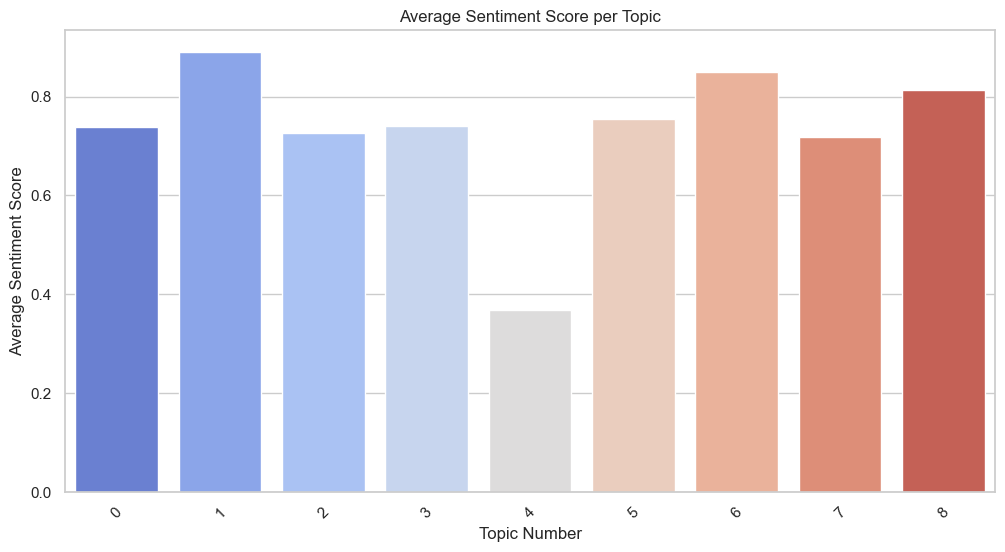

In [19]:
plt.figure(figsize=(12,6))
sns.barplot(x='Dominant_Topic', y='Average_Sentiment_Score', data=topic_sentiments, palette='coolwarm')
plt.title('Average Sentiment Score per Topic')
plt.xlabel('Topic Number')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.show()